In [1]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
import numpy
import os

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

This notebook requires the package `obs_lsst`, which is not currently distributed in the LSP. If the following cell raises an exception, see the instructions in `welcome_to_FE55.ipynb`.

In [3]:
import eups
assert eups.getSetupVersion("obs_lsst")

In [4]:
my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'


afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, 
                                    name=my_channel)

In [5]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FLAT', 'testType': 'FLAT'})

In [6]:
dId = {'visit': visits[0], 'detector': 2}
raw = butler.get('raw', **dId)

In [7]:
detector = raw.getDetector()

In [8]:
afw_display.mtv(raw)

In [9]:
# for the geometry we've chosen, the y=0 amps are in the top
# Normally the read corner would tell you this, but there is currently a bug
flipXY = {'C00':(False, True),
          'C01':(False, True),
          'C02':(False, True),
          'C03':(False, True),
          'C04':(False, True),
          'C05':(False, True),
          'C06':(False, True),
          'C07':(False, True),
          'C10':(True, False),
          'C11':(True, False),
          'C12':(True, False),
          'C13':(True, False),
          'C14':(True, False),
          'C15':(True, False),
          'C16':(True, False),
          'C17':(True, False)}

In [10]:
overscans = {}
for key, value in flipXY.items():
    bbox = detector[key].getRawHorizontalOverscanBBox()
    overscans[key] = raw[bbox].getMaskedImage().getImage().clone() # since these are views into the pixels, we want a copy so we don't mess with the pixels in the original image

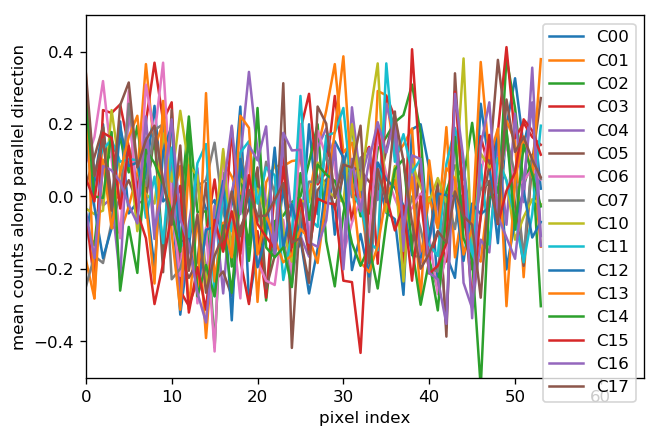

In [11]:
for channel_name, flips in flipXY.items():
    # get all the overscans in the same orientation and plot the mean along the y-axis
    arr = overscans[channel_name].getArray() # pull out numpy array
    oscan = numpy.mean(arr)
    fx, fy = flips
    if fx:
        arr = numpy.flip(arr, axis=1)
    if fy:
        arr = numpy.flip(arr, axis=0)
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    mean = numpy.mean(arr, axis=0)
    plt.plot(mean-oscan, label=channel_name)

plt.xlabel('pixel index')
plt.ylabel('mean counts along parallel direction')
plt.xlim(0, 65)
plt.ylim(-0.5, 0.5)
plt.legend()

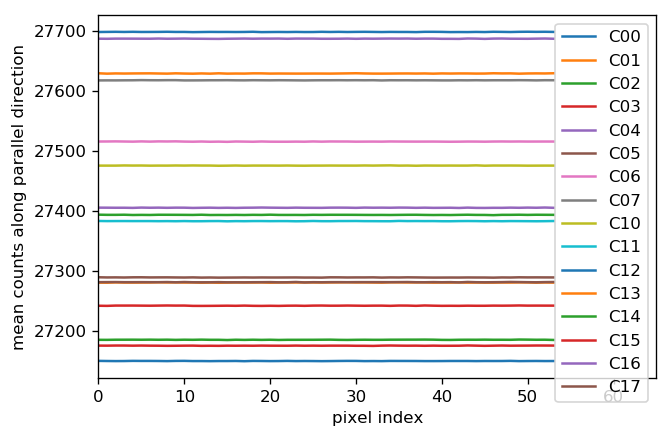

In [15]:
for channel_name, flips in flipXY.items():
    # get all the overscans in the same orientation and plot the mean along the y-axis
    arr = overscans[channel_name].getArray() # pull out numpy array
    oscan = numpy.mean(arr)
    fx, fy = flips
    if fx:
        arr = numpy.flip(arr, axis=1)
    if fy:
        arr = numpy.flip(arr, axis=0)
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    mean = numpy.mean(arr, axis=0)
    plt.plot(mean, label=channel_name)

plt.xlabel('pixel index')
plt.ylabel('mean counts along parallel direction')
plt.xlim(0, 65)
#plt.ylim(-0.5, 0.5)
plt.legend()